In [27]:
from utilities import *
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns

In [68]:
num_nodes = 1000
mean_degree = 20
ythreshold = 0.07 #threshold on eigenvector components

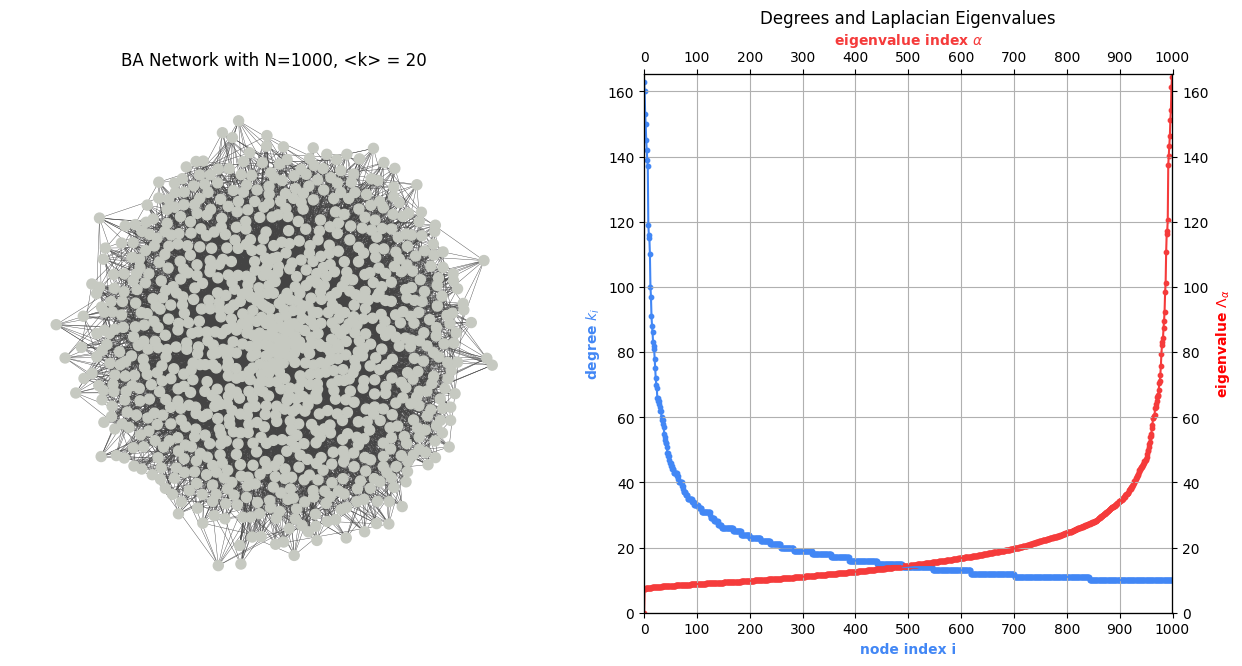

In [81]:
m = int(mean_degree/2)  
ba_graph = ig.Graph.Barabasi(n=num_nodes, m=m)
degrees = ba_graph.degree()
sorted_indices = sorted(range(len(degrees)), key=lambda k: degrees[k], reverse=True)
new_indices = {old_idx: new_idx for new_idx, old_idx in enumerate(sorted_indices)}
reindexed_edges = [(new_indices[edge.source], new_indices[edge.target]) for edge in ba_graph.es]

graph = ig.Graph(edges=reindexed_edges)
degrees = graph.degree()
assumed_degrees = np.unique(degrees) # np.unique(degrees) automatically sorts in increasing order
laplacian_matrix = np.array(graph.laplacian())
eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix) # L = D-Alaplacian_matrix = np.array(graph.laplacian())




layout = graph.layout("fruchterman_reingold")  # Kamada-Kawai layout

fig, axs = plt.subplots(1, 2, figsize=(15, 7)) 
ig.plot(
    graph, 
    layout=layout, 
    target=axs[0], 
    bbox=(800, 800), 
    margin=20, 
    vertex_size=10,
    edge_width=0.3,
    vertex_color = "#c6c9c1",
    vertex_frame_color = "#c6c9c1"
)
axs[0].set_title(f"BA Network with N={num_nodes}, <k> = {mean_degree}")

axs[1].plot(
    range(num_nodes),
    degrees,
    color="#4287f5",
    )
axs[1].scatter(
    range(num_nodes),
    degrees,
    color="#4287f5",
    s = 10
    )
axs[1].set_xlabel("node index i",  color = "#4287f5", fontdict={'weight': 'bold'})
axs[1].set_ylabel(r"degree $k_i$", color = "#4287f5", fontdict={'weight': 'bold'})

######################################################################################
c = "#f53b3b"
secax_x = axs[1].twiny()
secax_x.set_xlabel(r"eigenvalue index $\alpha$", color=c, fontdict={'weight': 'bold'})
secax_x.xaxis.set_label_position('top')
axs[1].set_xlim(0, num_nodes )
secax_x.set_xlim(0, num_nodes)
axs[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
secax_x.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

secax_y = axs[1].twinx()
secax_y.set_ylabel(r"eigenvalue $\Lambda_α$", color="red", fontdict={'weight': 'bold'})
secax_y.yaxis.set_label_position('right')
upper_limits = [max(degrees), max(eigenvalues)]
axs[1].set_ylim(0, max(upper_limits)+1)
secax_y.set_ylim(0, max(upper_limits)+1)
axs[1].yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
secax_y.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

axs[1].plot(
    range(num_nodes),
    eigenvalues,
    color=c,
    )
axs[1].scatter(
    range(num_nodes),
    eigenvalues,
    color=c,
    s = 10
    )
axs[1].set_title("Degrees and Laplacian Eigenvalues")
axs[1].grid(True)

plt.savefig(f"figures/network_{num_nodes}.pdf")

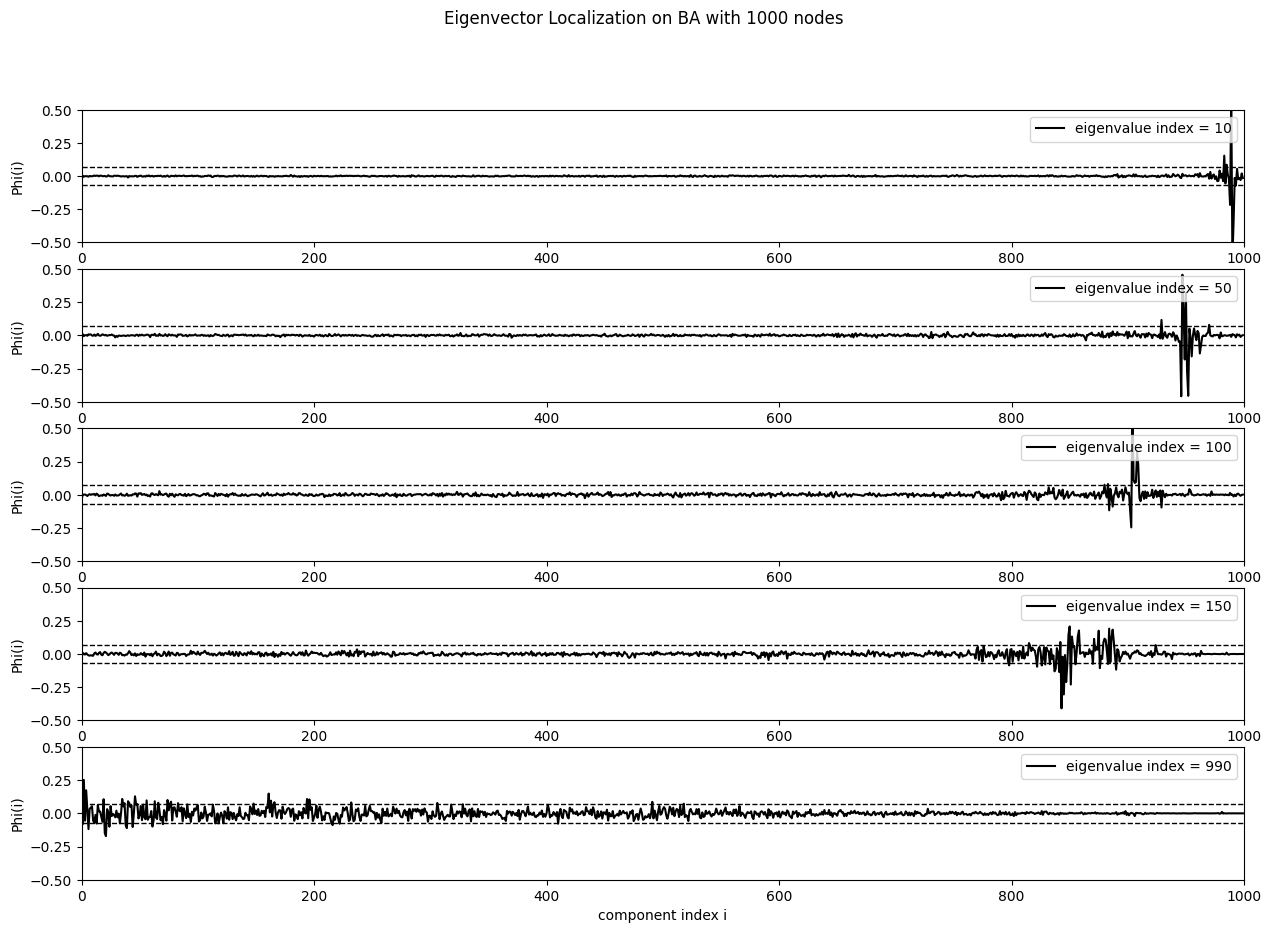

In [69]:
indices = [10, 50, 100, 150, num_nodes - 10]


fig, axs = plt.subplots(len(indices), 1, figsize=(15, 10)) 
plt.suptitle(f"Eigenvector Localization on BA with {num_nodes} nodes")

for i,id in enumerate(indices):
    eigenvector = eigenvectors[id]
    axs[i].plot(
        range(num_nodes),
        [eigenvector[n] for n in range(num_nodes)],
        color="black",
        )
    axs[i].set_xlim(0, num_nodes)
    axs[i].set_ylim(-0.5, +0.5)
    axs[i].set_xlabel("")
    axs[i].set_ylabel(f"Phi(i)")
    axs[i].legend([f"eigenvalue index = {id}"], loc='upper right')
    axs[i].axhline(y= + ythreshold, color='black', linestyle='--', linewidth = 1)
    axs[i].axhline(y=- ythreshold, color='black', linestyle='--', linewidth = 1)
axs[len(indices)-1].set_xlabel("component index i")

plt.savefig(f"figures/eigenvectors_{num_nodes}.pdf")

In [98]:
data = []
k_groups_populations = []

min_degree = m
max_degree = num_nodes -1
running_degrees = np.arange(min_degree, max_degree + 1)

for k in assumed_degrees:
    n_k = 0
    for i in np.arange(0, num_nodes):
        if degrees[i] == k:
            n_k += 1
    k_groups_populations.append(n_k)


M = np.zeros((num_nodes, len(assumed_degrees)))
for i, eig in enumerate(eigenvalues):
    v = eigenvectors[i]
    k_groups_differentiated_populations = []

    for k_index, k in enumerate(assumed_degrees):
        if k_groups_populations[k_index] != 0:
            n_k = 0
            for i in np.arange(0, num_nodes):
                if (degrees[i] == k) and (abs(v[i]) > ythreshold):
                    n_k += 1
            k_groups_differentiated_populations.append(n_k)
            density = n_k/k_groups_populations[k_index] * 100
        else:
            density = 0
        M[i, k_index] = density
        data.append({'eigenvalue_index': i, 'eigenvalue': eig, 'degree': k , 'number': n_k, 'density': density})

df = pd.DataFrame(data)
df.to_csv(f'csv_outputs/prova_{num_nodes}.csv', index=False)

In [80]:
k_df = df[df['eigenvalue'] == 'null']

temp = df[df['eigenvalue'] != 'null']
temp = temp[['eigenvalue', 'degree', 'nodes_number']]

for index, row in temp.iterrows():
    krow = k_df[k_df['degree'] == row['degree']]
    population = krow['nodes_number'].iloc[0]
    temp.at[index, 'nodes_number'] = row['nodes_number']/ population


temp['eigenvalue'] = pd.to_numeric(temp['eigenvalue'], errors='coerce')
temp['degree'] = pd.to_numeric(temp['degree'], errors='coerce')
temp['nodes_number'] = pd.to_numeric(temp['nodes_number'], errors='coerce')
temp = temp.dropna()

temp.to_csv(f"csv_outputs/differentiated_nodes_{num_nodes}.csv",  index=False)

/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_1128/833270658.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.012195121951219513' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp.at[index, 'nodes_number'] = row['nodes_number']/ population


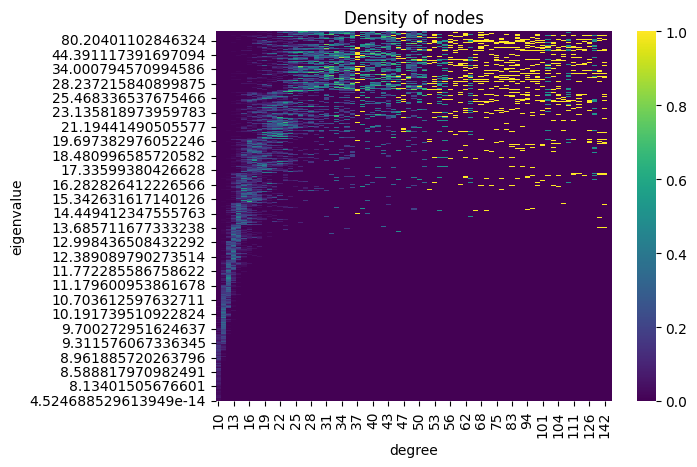

In [76]:
pivot_table = temp.pivot_table(index='eigenvalue', columns='degree', values='nodes_number', aggfunc='mean')

fig, ax = plt.subplots()

ax.set_xlim(m, max(degrees))
ax.set_ylim(0, max(eigenvalues))
# Reverse the y-axis
ax.set_xlabel('degree k')
ax.set_ylabel(r'eigenvalue $\Lambda$')
#ax.set_xlabel(r'$\log{k}$')
#ax.set_ylabel(r'$\log{\Lambda}$')
plt.title('Density of nodes')

sns.heatmap(pivot_table, cmap='viridis', ax=ax)
ax.invert_yaxis()

plt.show()

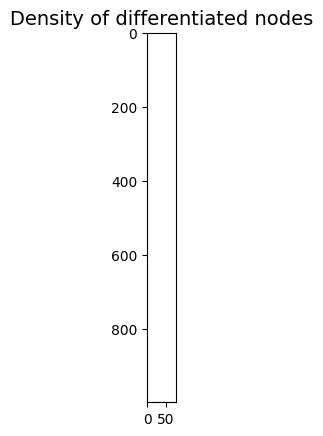

In [101]:
fig, ax = plt.subplots()
ax.set_title("Density of differentiated nodes", fontsize = 14)
ax.imshow(M, cmap='Greys')

#ax.set_xticks(np.arange(0,8))
#ax.set_yticks(np.arange(0,8))
#ax.set_xticklabels(['1','2','3','4','5', '6', '7', '8'], fontsize = 14)
#ax.set_yticklabels(['1','2','3','4','5', '6', '7', '8'], fontsize = 14)
